In [1]:
import matplotlib.pyplot as plt
from torch import nn
import torch
from scipy.integrate import solve_ivp
import numpy as np

## Harmonic Oscillators

Oscillatory motion is a fundamental phenomenon observed throughout nature, from the vibrations of atoms in molecules, to foundations of Quantum field theory,  to the swaying of bridges. At the heart of such periodic behavior lies the harmonic oscillator, a idealized system that experiences a restoring force proportional to its displacement from equilibrium. A classic example is a mass-spring system: when displaced, the mass undergoes sinusoidal oscillations around its equilibrium position, governed by the following equation.

$ m \frac{d^{2}x}{dt^{2}} + kx = 0$

In presence of a damping term , the behaviour of the system drastically changes. The damped harmonic oscillator can be represented using the following differential equation:

$ m \frac{d^{2}x}{dt} + b\frac{dx}{dt} +  kx = 0$.

The equation of motion becomes md2xdt2+bdxdt+kx=0mdt2d2x​+bdtdx​+kx=0, drastically altering the system's behavior. Damping causes the amplitude of oscillations to decay over time, eventually bringing the system to rest. Depending on the damping strength bb, the motion may exhibit three regimes: underdamped (oscillations with diminishing amplitude), critically damped (fastest return to equilibrium without oscillation), or overdamped (slow, non-oscillatory decay).

#### Solving the Damped Harmonic Oscillator using Traditional Numerical solvers. (scipy.integrate)

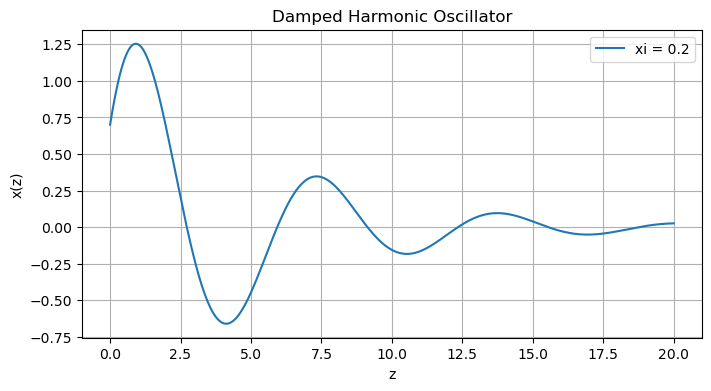

In [2]:
import numpy as np

import matplotlib.pyplot as plt

# Define the damped oscillator ODE system.
# Let y[0] = x and y[1] = dx/dz.
def damped_oscillator(z, y, xi):
    dxdz = y[1]
    d2xdz2 = -2 * xi * y[1] - y[0]
    return [dxdz, d2xdz2]

# Set parameters
xi = 0.2              # Damping ratio (example value, can vary between 0.1 and 0.4)
z_start, z_end = 0, 20  # Domain for z
z_eval = np.linspace(z_start, z_end, 400)  # Evaluation points
y0 = [0.7, 1.2]       # Initial conditions: x(0)=0.7 and dx/dz(0)=1.2

# Solve the ODE using solve_ivp
sol = solve_ivp(damped_oscillator, (z_start, z_end), y0, args=(xi,), t_eval=z_eval)

# Plot the solution
plt.figure(figsize=(8, 4))
plt.plot(sol.t, sol.y[0], label=f"xi = {xi}")
plt.xlabel("z")
plt.ylabel("x(z)")
plt.title("Damped Harmonic Oscillator")
plt.legend()
plt.show()


### Physics informed Neural networks.

[NIAVE APPROACH]


The traditional solvers usually discretize the domain, approximate derivatives, and iteratively compute solutions with high precision.While robust for well-posed problems, they face limitations in handling noisy or sparse data, high-dimensional systems, and inverse problems where parameters must be inferred from observations. Furthermore, traditional solvers often require domain-specific tuning, struggle with parameterized systems, and scale poorly with complexity. On the other hand, Physics Informed Neural networks tries to find the solution by approximating the solution as a neural network and contrain the solution to satify the boundary conditions and the differential equation under consideration. And Because of the Universal approximation Theorems for neural networks, It could be possible to find a set of weights for the neural network that satistfies these two loss functions. (Physical loss term and boundary condition).

[IMPROVEMENTS FROM VANILLA PINN : ]



1.   Design the Anzat of the solution (using Neural network) to satisfy the intial conditions exactly. This will prevent us from having multiple loss functions and need for specialsed methods for Multiobjective optimisation techniques.
2.   Since we already know the domain in which we are interested in the solution, we can rescale the problem in an invertible manner to a domain for t in [0,1]
3. Augmented Lagrangian Method for putting hardconstrains on the Ansat to satisfy the ODE equation.



## Rescaling the domain

Actual equation :  $ \frac{d^{2}x}{dz^{2}} + 2ξ. \frac{dx}{dz} + x = 0 $

Let $t = \frac{z}{20}$ so $z = 20t$

Then we will have: $\frac{d}{dz} = \frac{d}{dt}.\frac{dt}{dz} = \frac{1}{20}.\frac{d}{dt}  $

Similarly
$\frac{d^{2}}{dz^{2}} = \frac{d^{2}}{dt^{2}}.\frac{1}{20^{2}} $

So , Our Differential equation becomes the following :
 $ \frac{1}{20^{2}}.\frac{d^{2}x}{dt^{2}} + 2ξ. \frac{1}{20}.\frac{dx}{dt} + x = 0 $

This can be normalised to
 $ \frac{d^{2}x}{dt^{2}} + 40ξ.\frac{dx}{dt} + 400x = 0 $


 This resacling should help in stabilising the training process by making the input space to the nueral networks compact and thus preventing gradient shooting. This also prevents satuartion of gradient functions and stabilise the training process, especially when training with



## Hard Constraint for inital conditions

$x_0 = 0.7$

$v_0 = 1.2$

Usually in the standar vanilla PINN, the solution $U(t)$ is modelled as $NN(\theta) and the parameters of the neural network is optimised using physics loss term (ODE residue) and another term for initial conditions (and any other data point availabe)

[Hard constraint for initial conditions]

Instead We now model the solution of the ODE with the following Ansat.

$U(t) = x_0 + 20t.v_0 + t^{2}.NN(\theta)$

The advantage here that  $U(0)$ will always be x_0 and $ \frac{dU}{dt} = 20.v_0 $(adjusting for the rescaling)

In [3]:
def set_seed(seed=42):
    '''
    Seeding the random variables for reproducibility
    '''
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [4]:
class PhysicsNN(nn.Module):
    def __init__(self):
        super(PhysicsNN, self).__init__()
        self.x0 = 0.7  ## initial condition on inital position
        self.v0 = 1.2  ## initial condition on initial velocity

        # Input layer
        self.linear_in = nn.Linear(2, 32) #(Input: t, xi )
        # Output layer
        self.linear_out = nn.Linear(32, 1)
        # Hidden layers
        self.layers = nn.ModuleList(
            [nn.Linear(32, 32) for i in range(2)]
        )
        # Activation function
        self.act = nn.Tanh()

    def forward(self, t: torch.Tensor, xi : torch.Tensor) -> torch.Tensor:
        out = self.linear_in(torch.cat([t, xi], dim=1)) ## concatenating t and xi values
        out = self.act(out)
        for layer in self.layers:
            out = self.act(layer(out))
        out = self.linear_out(out)
        return self.x0 + 20*t*self.v0 + torch.pow(t,2)*out ### Hard constraining initial conditions


In [5]:
def derivative(model: PhysicsNN, t_f: torch.Tensor, xi: torch.Tensor ,order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the model at t_f
    """
    t_f.requires_grad_(True)
    dy = model(t_f, xi)
    for i in range(order):
        dy = torch.autograd.grad(
            dy, t_f, grad_outputs = torch.ones_like(t_f), create_graph=True, retain_graph=True
        )[0]
    return dy

In [6]:
def u_function(model: PhysicsNN, t: torch.Tensor, xi: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the model on the input x
    """
    return model(t,xi)

In [7]:
def f(model: PhysicsNN, t_f: torch.Tensor, xi: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the physics governing the model on the input t_f
    """
    u = u_function(model, t_f,xi)
    dudt = derivative(model, t_f, xi, order = 1)
    d2udt2 = derivative(model, t_f, xi, order = 2)
    f = d2udt2 + 40*xi*dudt + 400*u
    return f

In [8]:

def loss_function(model: PhysicsNN, t_f: torch.Tensor, xi : torch.Tensor) -> torch.Tensor:
    miu = 4
    k = 400
    # Loss associated with the physics governing the model
    MSE_f = f(model, t_f, xi).pow(2).mean()
    return MSE_f


In [23]:

def train(model: PhysicsNN):
    """
    This function trains the model on the input data
    """
    model.load_state_dict(torch.load('/global/homes/s/sijilj/PINN/model_parameters.pth'))
    epoch = 500000
    lr = 3e-4

    # grid points


    # Create a grid of points
    t = np.linspace(0, 1, 500)
    xi = np.linspace(0.1, 0.4, 500)
    # Create a grid of points
    T, XI = np.meshgrid(t, xi)
    T = torch.Tensor(T)
    XI = torch.Tensor(XI)
    T_flat = T.flatten()
    XI_flat = XI.flatten()
    T_flat  = T_flat[:,None].to(device)
    XI_flat  = XI_flat[:,None].to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_list = []
    for epoch in range(epoch):
        optimizer.zero_grad()
        loss = loss_function(model, T_flat,  XI_flat)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
          loss_list.append(loss.item())
          # Sample collocation points
          t_eval = torch.rand(1000, 1)          # z ∈ [0, 1]
          xi_eval = torch.rand(1000, 1) * 0.3 + 0.1  # ξ ∈ [0.1, 0.4]
          # Evaluation part
          # Evaluate the model
          eval_loss = loss_function(model,t_eval.to(device) , xi_eval.to(device))
          print(f"Epoch: {epoch}, Loss: {loss.item()}, Loss_eval : {eval_loss.item()}")
          torch.save(model.state_dict(), '/global/homes/s/sijilj/PINN/model_parameters.pth')
    return model, loss_list

In [45]:
set_seed(42)

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Training on CPU.")
# Instantiating the model
model = PhysicsNN().to(device)

model, loss_list = train(model)



GPU is available. Training on GPU.
Epoch: 0, Loss: 0.47742941975593567, Loss_eval : 781.168212890625
Epoch: 1000, Loss: 0.47639718651771545, Loss_eval : 0.05396951735019684
Epoch: 2000, Loss: 0.4785880446434021, Loss_eval : 0.15011650323867798
Epoch: 3000, Loss: 0.47604793310165405, Loss_eval : 152.59214782714844
Epoch: 4000, Loss: 0.5004226565361023, Loss_eval : 12.707748413085938
Epoch: 5000, Loss: 0.4759258031845093, Loss_eval : 0.03424104303121567
Epoch: 6000, Loss: 0.47585800290107727, Loss_eval : 0.06554243713617325
Epoch: 7000, Loss: 0.4757060110569, Loss_eval : 64.05796813964844
Epoch: 8000, Loss: 0.47549787163734436, Loss_eval : 0.8844324350357056
Epoch: 9000, Loss: 1.4278749227523804, Loss_eval : 41.74599075317383
Epoch: 10000, Loss: 0.47553345561027527, Loss_eval : 24.422744750976562
Epoch: 11000, Loss: 0.47533777356147766, Loss_eval : 0.17252813279628754
Epoch: 12000, Loss: 0.47515669465065, Loss_eval : 8.736750602722168
Epoch: 13000, Loss: 0.47518840432167053, Loss_eval : 

###  Analysing the Trained Model : 
1. Comparision with the traditional numerical solution
2. Phase space trajectory
3. Heat map to check the ODE residue at different grid points.

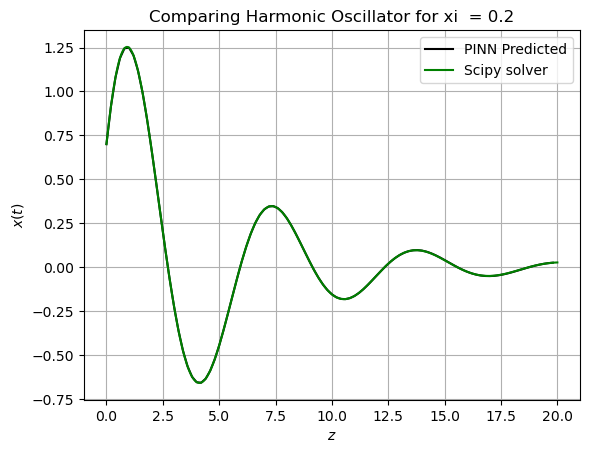

In [46]:

## Comparision of trained solver with traditional solver

t_eval = torch.arange(0, 1, 0.01).to(device)          # z ∈ [0, 1]
xi_eval = (torch.ones(100) * 0.2).to(device)

# Plotting the results
u_f = model(t_eval[:,None], xi_eval[:,None]).detach().to('cpu').numpy()
t_f = t_eval.detach().to('cpu').numpy()*20
#u_f = u_f.detach().to('cpu').numpy()
plt.plot( t_f,u_f, color = 'k', label = "PINN Predicted")
plt.plot(sol.t, sol.y[0], color = 'g', label=f"Scipy solver")
#plt.scatter(x_u.detach().numpy(),y_u.detach().numpy(), label = "Initial",color ='r' )
plt.title("Comparing Harmonic Oscillator for xi  = 0.2")
plt.ylabel(r"$x(t)$")
plt.xlabel(r"$z$")
plt.grid(True)
plt.legend()
#plt.savefig("/content/drive/MyDrive/Physics informed neural network/Harmonic_Oscilator.png", dpi = 100)
plt.show()



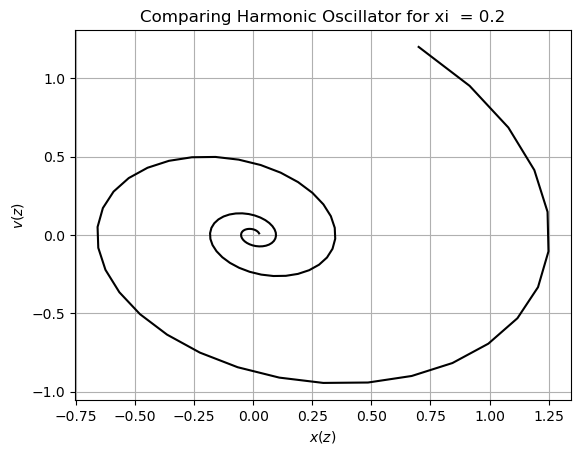

In [52]:
t_eval = torch.arange(0, 1, 0.01).to(device) 
xi_eval = (torch.ones(100) * 0.2).to(device)

u_f = model(t_eval[:,None], xi_eval[:,None]).detach().to('cpu').numpy() ## position
du_dz =  derivative(model, t_eval[:,None], xi_eval[:,None],order = 1).detach().to('cpu').numpy()*(1/20) ## velocity

plt.plot( u_f,du_dz, color = 'k', label = "dg")
#plt.plot(sol.t, sol.y[0], color = 'g', label=f"Scipy solver")
#plt.scatter(x_u.detach().numpy(),y_u.detach().numpy(), label = "Initial",color ='r' )
plt.title("Comparing Harmonic Oscillator for xi  = 0.2")
plt.ylabel(r"$v(z)$")
plt.xlabel(r"$x(z)$")
plt.grid(True)
#plt.savefig("/content/drive/MyDrive/Physics informed neural network/Harmonic_Oscilator.png", dpi = 100)
plt.show()



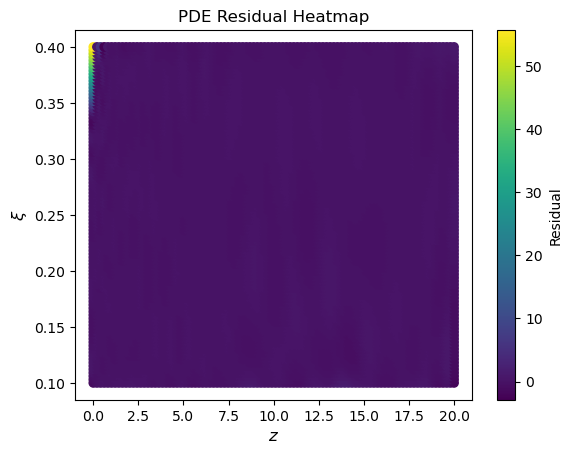

In [57]:
## Verifying PDE Compilance accross the domain :
# Create a grid of points
t = np.linspace(0, 1, 100)
xi = np.linspace(0.1, 0.4, 100)
# Create a grid of points
T, XI = np.meshgrid(t, xi)
T = torch.Tensor(T)
XI = torch.Tensor(XI)
T_flat = T.flatten()
XI_flat = XI.flatten()
T_flat  = T_flat[:,None].to(device)
XI_flat  = XI_flat[:,None].to(device)

residue = f(model, T_flat, XI_flat)

plt.scatter(T.detach().to('cpu').numpy()*20, XI.detach().to('cpu').numpy(), c=residue.detach().to('cpu').numpy(), cmap='viridis')
plt.colorbar(label='Residual')
plt.xlabel('$z$', fontsize=12)
plt.ylabel('$\\xi$', fontsize=12)
plt.title('PDE Residual Heatmap')
plt.show()



The results seem acceptable with this level of training using a neural network of 2 hidden layers.We can further improve the results especially in the initial region with $\xi = [0.35 , 0.4]$ with using networks with more repressentation power.